In [1]:
import math
import time
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split
from torchvision import transforms, datasets
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from tqdm import tqdm, trange

In [2]:
import logging

# Clear existing handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Now reconfigure
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("training_log.txt", mode="w")
    ]
)

In [3]:
class TransformedDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [4]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

In [5]:
train_dataset = datasets.CIFAR100(root="./data", train=True, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, download=True)

In [6]:
val_size = 5000
train_size = len(train_dataset) - val_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

CIFAR100_train = TransformedDataset(train_set, train_transform)
CIFAR100_val = TransformedDataset(val_set, val_test_transform)
CIFAR100_test = TransformedDataset(test_dataset, val_test_transform)

In [7]:
print(len(CIFAR100_train))
print(len(CIFAR100_val))
print(len(CIFAR100_test))

45000
5000
10000


In [8]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growthRate):
        super(Bottleneck, self).__init__()
        inter_channels = 4 * growthRate
        self.dropout1 = nn.Dropout2d(0.2)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, inter_channels, kernel_size=1, bias=False)
        self.dropout2 = nn.Dropout2d(0.2)
        self.bn2 = nn.BatchNorm2d(inter_channels)
        self.conv2 = nn.Conv2d(inter_channels, growthRate, kernel_size=3, padding=1, bias=False)
       
    def forward(self, x):
        y = self.dropout1(x)
        y = self.conv1(F.relu(self.bn1(y)))
        y = self.dropout2(y)
        y = self.conv2(F.relu(self.bn2(y)))
        return y

In [9]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growthRate, nums_bottleneck):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(nums_bottleneck):
            layers.append(Bottleneck(in_channels=in_channels, growthRate=growthRate))
            in_channels += growthRate
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        for layer in self.net:
            y = layer(x)
            x = torch.cat((x, y), dim=1)
        return x

In [10]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
    
    def forward(self, x):
        y = self.conv1(F.relu(self.bn1(x)))
        y = F.avg_pool2d(y, kernel_size=2, stride=2)
        return y

In [11]:
class Net(nn.Module):
    def __init__(self, depth, growthRate, compression_factor, num_classes):
        super(Net, self).__init__()
        nums_bottleneck = (depth - 4) // 3 // 2      # (100 - 4) // 3 // 2 = 16  
        out_channels = 2 * growthRate    # Initialize out_channels

        self.initial_layer = nn.Conv2d(3, out_channels, kernel_size=3, padding=1, bias=False)       # Shape: (3, 32, 32) -> (24, 32, 32)

        self.dense_block_1 = DenseBlock(in_channels=out_channels, growthRate=growthRate, nums_bottleneck=nums_bottleneck)   # Shape: (24, 32, 32) -> (216, 32, 32)
        out_channels += growthRate * nums_bottleneck    # Update out_channels from 24 -> 216
        halved_channels = int(math.floor(out_channels * compression_factor))     # Halved_channels = 108
        self.transition_layer_1 = TransitionLayer(in_channels=out_channels, out_channels=halved_channels)       # Shape: (216, 32, 32) -> (108, 16, 16)

        out_channels = halved_channels      # Update out_channels from 216 -> 108

        self.dense_block_2 = DenseBlock(in_channels=out_channels, growthRate=growthRate, nums_bottleneck=nums_bottleneck)   # Shape: (108, 16, 16) -> (300, 16, 16)
        out_channels += growthRate * nums_bottleneck    # Update out_channels from 108 -> 300
        halved_channels = int(math.floor(out_channels * compression_factor))     # Halved_channels = 150
        self.transition_layer_2 = TransitionLayer(in_channels=out_channels, out_channels=halved_channels)       # Shape: (300, 16, 16)  -> (150, 8, 8)

        out_channels = halved_channels      # Update out_channels from 300 -> 150
    
        self.dense_block_3 = DenseBlock(in_channels=out_channels, growthRate=growthRate, nums_bottleneck=nums_bottleneck)   # Shape: (150, 8, 8) -> (342, 8, 8)
        out_channels += growthRate * nums_bottleneck    # Update out_channels 150 -> 342

        self.bn = nn.BatchNorm2d(out_channels)
        self.avg = nn.AdaptiveAvgPool2d((1, 1))     # Shape: (342, 8, 8) -> (342, 1, 1)
        self.flattener = nn.Flatten()               # Shape: (342, 1, 1) -> (342)
        self.classifier = nn.Linear(out_channels, num_classes)   # Shape: (342) -> (100)
    
    def forward(self, x):
        x = self.initial_layer(x)
        x = self.transition_layer_1(self.dense_block_1(x))
        x = self.transition_layer_2(self.dense_block_2(x))
        x = self.dense_block_3(x)
        x = F.relu(self.bn(x))
        x = self.avg(x)
        x = self.flattener(x)
        x = self.classifier(x)
        return x

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

cuda
NVIDIA GeForce RTX 3060


In [13]:
# L = 100, k = 12, theta = 0.5, 10 classes to classify
net = Net(depth=100, growthRate=12, compression_factor=0.5, num_classes=100).to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
         Dropout2d-2           [-1, 24, 32, 32]               0
       BatchNorm2d-3           [-1, 24, 32, 32]              48
            Conv2d-4           [-1, 48, 32, 32]           1,152
         Dropout2d-5           [-1, 48, 32, 32]               0
       BatchNorm2d-6           [-1, 48, 32, 32]              96
            Conv2d-7           [-1, 12, 32, 32]           5,184
        Bottleneck-8           [-1, 12, 32, 32]               0
         Dropout2d-9           [-1, 36, 32, 32]               0
      BatchNorm2d-10           [-1, 36, 32, 32]              72
           Conv2d-11           [-1, 48, 32, 32]           1,728
        Dropout2d-12           [-1, 48, 32, 32]               0
      BatchNorm2d-13           [-1, 48, 32, 32]              96
           Conv2d-14           [-1, 12,

In [14]:
x = torch.rand((64, 3, 32, 32)).to(device)      # Test the Net
net(x).shape

torch.Size([64, 100])

In [15]:
def evaluate(net: nn.Module,
             data_loader: torch.utils.data.DataLoader) -> float:
  
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        with tqdm(total=len(data_loader), leave=True, desc=f"Evaluating progress: ", ncols=100) as pbar:
            for batch_idx, (inputs, targets) in enumerate(data_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                pred_target = net(inputs).argmax(dim=1)
                correct += (pred_target == targets).sum().item()
                total += targets.size(0)
                pbar.update(1)

    return correct / total

In [16]:
def train(train_data,
          val_data,
          net,
          **kwargs):
          
    start_time = time.time()
    torch.cuda.reset_peak_memory_stats()

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    train_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=kwargs['batch_size'],
                                                shuffle=True, num_workers=0, pin_memory=False)
    
    val_loader = torch.utils.data.DataLoader(val_data,
                                                batch_size=kwargs['batch_size'],
                                                shuffle=False, num_workers=0, pin_memory=False)
  
    optimizer = opt.SGD(net.parameters(), lr=kwargs['lr'], momentum=0.9, weight_decay=1e-4, nesterov=True)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 225], gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    scaler = torch.GradScaler(device="cuda")
    best_val_loss = 10
    best_epoch = 0 

    for epoch in range(kwargs['epochs']):
        net.train()
        train_loss = 0
        with tqdm(total=len(train_loader), leave=True, desc=f"Epoch {epoch+1}/{kwargs['epochs']}", ncols=100) as pbar:
            for batch_idx, (inputs, targets) in enumerate(train_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                with torch.autocast(device_type="cuda"):
                    pred_targets = net(inputs)
                    loss = criterion(pred_targets, targets)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                train_loss += loss.item()
                pbar.update(1)

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        net.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                with torch.autocast(device_type="cuda"):
                    pred_targets = net(inputs)
                    loss = criterion(pred_targets, targets)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        scheduler.step()

     
        train_accuracy = evaluate(net, train_loader)
        train_accuracies.append(train_accuracy)
        
        val_accuracy = evaluate(net, val_loader)
        val_accuracies.append(val_accuracy)

        logging.info(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss} Val Acc: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(net.state_dict(), "best_model.pth")
            logging.info("Saved best model.")

    end_time = time.time()
    total_time = end_time - start_time
    peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # MB

    print(f"Total training time: {total_time:.2f} seconds")
    print(f"Peak GPU memory usage: {peak_memory:.2f} MB")

    return net, train_losses, val_losses, train_accuracies, val_accuracies, best_epoch

In [17]:
lr = 0.1
batch_size = 64
epochs = 300
net, train_losses, val_losses, train_accuracies, val_accuracies, best_epoch = train(train_data=CIFAR100_train,
                                            val_data=CIFAR100_val,
                                            net=net,
                                            lr=lr,
                                            batch_size=batch_size,
                                            epochs=epochs)

Evaluating progress: 100%|██████████████████████████████████████████| 79/79 [00:03<00:00, 20.41it/s]

Total training time: 36057.34 seconds
Peak GPU memory usage: 1115.58 MB


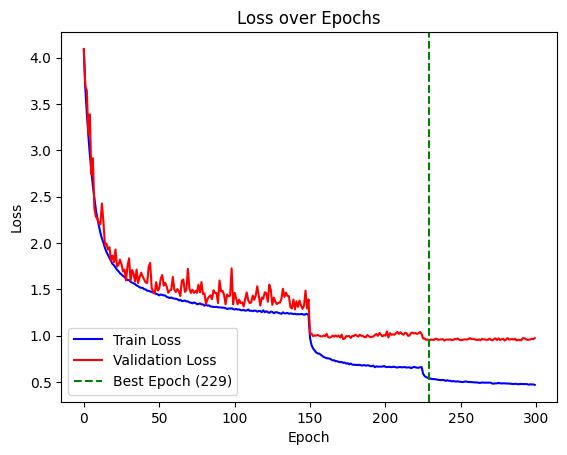

In [18]:
plt.plot(train_losses, label='Train Loss', c="blue")
plt.plot(val_losses, label='Validation Loss', c="red")
plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

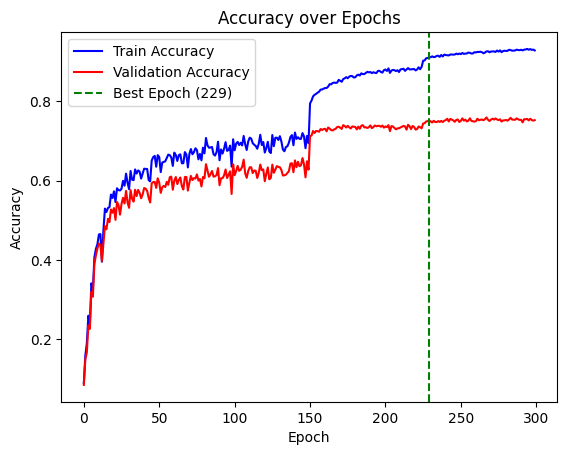

In [19]:
plt.plot(train_accuracies, label='Train Accuracy', c="blue")
plt.plot(val_accuracies, label='Validation Accuracy', c="red")
plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
test_loader = torch.utils.data.DataLoader(CIFAR100_test,
                                                batch_size=100,
                                                shuffle=False, num_workers=0, pin_memory=False)

In [21]:
net.load_state_dict(torch.load("best_model.pth"))
net.to(device)
net.eval()
test_accuracy = evaluate(net, test_loader)
print(f"Test accuracy: {test_accuracy:.4f}")

Evaluating progress: 100%|████████████████████████████████████████| 100/100 [00:06<00:00, 14.76it/s]

Test accuracy: 0.7434
